# Prévisions météorologiques en Australie

# Modélisation avec étape de ré-échantillonage

# Récupération des librairies

In [1]:
# récupération du package skater
# SUR UN TERMINAL: "conda install -c conda-forge Skater"

In [1]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [2]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time, datetime
import warnings
warnings.filterwarnings("ignore")

from skater.core.explanations import Interpretation
from sklearn.metrics import classification_report, accuracy_score
from skater.model import InMemoryModel
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler

# Modèle de classification par apprentissage supervisé

### Préparation du jeu de données et paramètrage

In [3]:
# récuperation et aperçu du jeu de données après prétraitement des données, après l'étape de classification des villes 
# en fonction du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [4]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [5]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement 
# à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [6]:
# undersampling des données
rUs = RandomUnderSampler()
X_train, y_train = rUs.fit_resample(X_train, y_train)

In [7]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible ré-échantillonnée:", dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible ré-échantillonnée: {0: 25005, 1: 25005}


In [8]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [9]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 21962, 1: 6196}


In [10]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [11]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# paramètre à initialiser pour définir la règle d'évaluation des modèles
scoring = 'accuracy' # considéré dans le cadre de cette étude
# scoring = 'f1'

### Séparateurs à Vaste Marge (SVM)

In [13]:
# définition du modèle: création d'un objet SVC (Support Vector Classificator)
clf_svm = SVC(probability=True, class_weight={0:2, 1:1})

# d'autres paramètres ont été considérés dans une étude préliminaire mais puisque les calculs étaient très long 
# à l'exécution, on ne garde ici que les paramètres qui ont donné les meilleurs résultats
param_grid_svm = {'kernel':['rbf'], 
                  'gamma':[0.5]}

gcv_svm = GridSearchCV(estimator=clf_svm, param_grid=param_grid_svm, scoring=scoring)

In [14]:
start_time = time.time()

# entraînement du modèle
grille = gcv_svm.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_svm.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_svm.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'gamma': 0.5, 'kernel': 'rbf'} 

Accuracy Score: 0.8361389303217558 

Train Data Score: 0.8270945810837832
Test Data Score: 0.8361389303217558

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            19491  2471
1             2143  4053

               precision    recall  f1-score   support

           0       0.90      0.89      0.89     21962
           1       0.62      0.65      0.64      6196

    accuracy                           0.84     28158
   macro avg       0.76      0.77      0.77     28158
weighted avg       0.84      0.84      0.84     28158

Running Time: 1:11:19.052419


- la méthode des K-plus proches voisins **ne fait pas l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.64.
- la spécificité (taux de vrais négatifs) vaut 0.89.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.89).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.64).

La classe '1' est caractérisée par une précision faible, ce qui signifie que la classe n'est pas très bien détectée, et un rappel faible, ce qui signifie que la classe inclut également des observations d'autres classes lorsqu'elle est détectée.

### Interprétation du modèle avec Skater

In [15]:
# conversion de l'ensemble d'entraînement standardisé en DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [17]:
# création d'un modèle
model = InMemoryModel(gcv_svm.predict_proba, examples=X_train_scaled)

In [18]:
# création d'une interprétation
interpreter = Interpretation(X_train_scaled, feature_names=X_train_scaled.columns)

In [19]:
# création d'un objet DataSet à partir des entrées, lié à l'interprétation
interpreter.load_data(X_train_scaled)

[13/13] features ████████████████████ Time elapsed: 1510 seconds

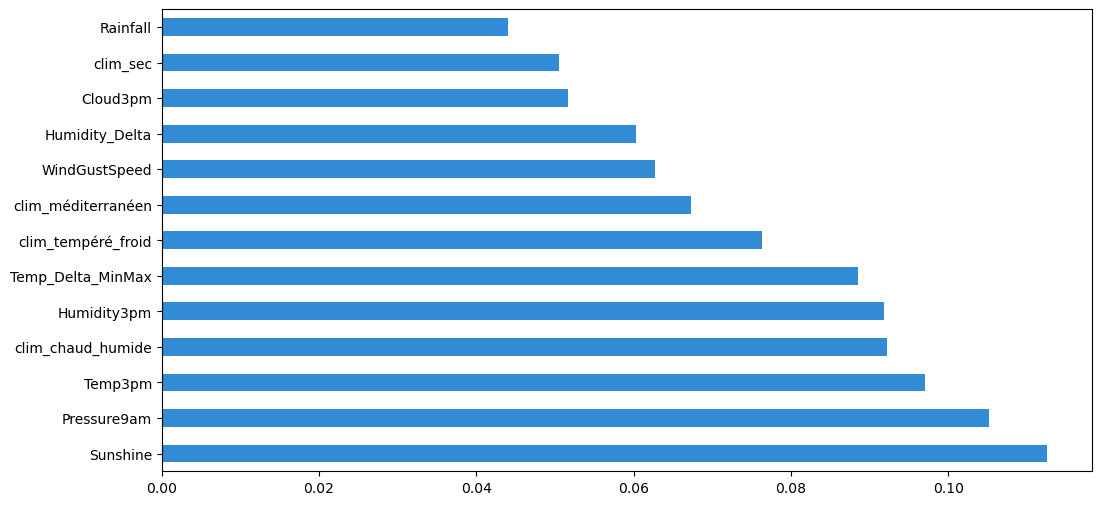

In [20]:
# affichage de l'importance des variables dans le jeu de données
plt.rcParams['figure.figsize'] = (12,6)
interpreter.feature_importance.plot_feature_importance(model, ascending=True);

Nous affichons ci-dessous les graphiques de dépendance partielle des variables ayant le plus d'importance pour mesurer individuellement leur impact sur la prédiction du modèle, lorsque les autres variables sont maintenues constantes. 

La dérivée de la dépendance partielle permet de décrire l'impact de chaque variable.

[69/69] grid cells ████████████████████ Time elapsed: 35 seconds

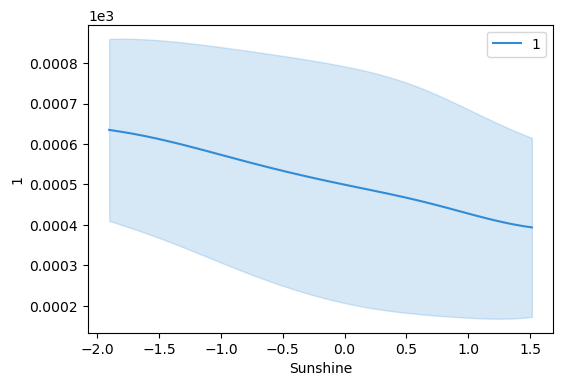

In [24]:
# affichage du graphique de dépendance partielle de la variable "Humidity_Delta"
interpreter.partial_dependence.plot_partial_dependence(
    ['Sunshine'], model, grid_resolution=100, with_variance=True, figsize=(6,4));

Plus l'ensoleillement est faible, plus il est probable qu'il pleuve le lendemain.

[100/100] grid cells ████████████████████ Time elapsed: 52 seconds

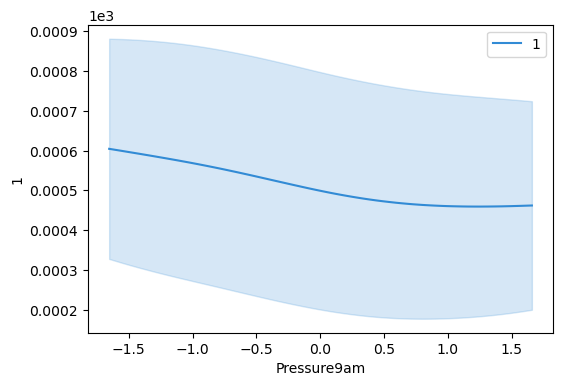

In [25]:
# affichage du graphique de dépendance partielle de la variable "Humidity3pm"
interpreter.partial_dependence.plot_partial_dependence(
    ['Pressure9am'], model, grid_resolution=100, with_variance=True, figsize=(6,4));

Plus la pression est faible à 9h, plus il est probable qu'il pleuve le lendemain.

[100/100] grid cells ████████████████████ Time elapsed: 60 seconds

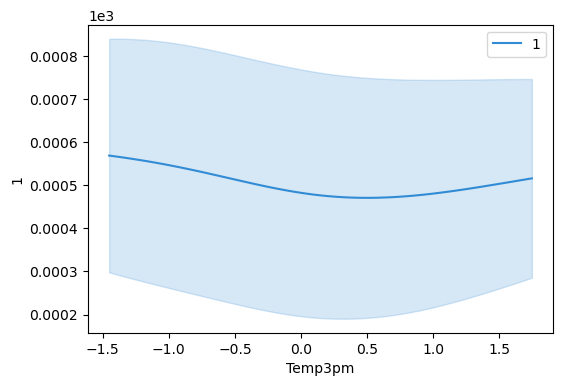

In [26]:
# affichage du graphique de dépendance partielle de la variable "Temp_Delta_MinMax"
interpreter.partial_dependence.plot_partial_dependence(
    ['Temp3pm'], model, grid_resolution=100, with_variance=True, figsize=(6,4));

Plus la température est faible à 15h, plus il est probable qu'il pleuve le lendemain.